# Objective
The goal with this project is to identify the best sources of protein, protein/kcal and the resulting cost effectiveness. My climbing friends and I want to find out what to buy when going on climbing trip, while on a budget.

Initial analysis will have a product selection based on cheapest options in various categories, pasta, chicken, tofu, etc.

## Tools
* Dataframes: Pandas
* Visualizations: Pandas, Matplotlib, Seaborn
* Scraping: BeautifulSoup, Request(re)
* Dashboards: Tableau

## Questions that we will answer
* What does protein contents look like in different products
* What amount of kcal do the products contain
* What do the products cost
* What is their cost/protein ration
* What is their cost/kcal ration
* What is their protein/kcal ration

## Question we won't answer, and limitations
* We will only look at data from Ica in Skärholmen and Liljeholmen
* The prices do not account for discounts
* Not a complete or balanced diet
* Not accounting for taste
* Not all products have a Kg/L price and won’t be counted
* Only comparing the given products

# Init notebook

Importing the tools and defining functions 

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pygsheets
import seaborn
import pandas as pd
import matplotlib.pyplot as plt

keypath = 'C:\\Users\Kaspe\Documents\AuthKeys\superfoods-383120-9880791a7067.json'
gc = pygsheets.authorize(service_file=keypath)
sh = gc.open("Super Foods")

# Scraping config

### Both prices we got had the same cleaning needs

In [3]:
def CleanPrice(numElement):
    numElement = numElement.get_text().strip().replace(u'\xa0', u' ')
    numElement = numElement.replace(u',', u'.')
    x = re.findall("\d+\.\d+", numElement)
    if(x):
        numElement = re.findall("\d+\.\d+", numElement)[0]
        return numElement
    else:
        return 0

### Scraping function

In [4]:
def InsertIcaProduct(df, url):
    response = requests.get(url)
    soup_data = BeautifulSoup(response.text, 'html.parser')
   
    title  = soup_data.findAll('h1', {"class": "heading__Base-sc-1vuwqc7-0-h1 sc-ehCIER ZBWKl rZSBo"})
    title = title[0].text.strip()

    kg_price = soup_data.findAll('span', {"class": "text__Text-sc-6l1yjp-0 bhymDA"})
    if(kg_price):
        if('st' in str(kg_price[1])):
            print('found unit price')
            kg_price = pd.NA
        else:
            kg_price = CleanPrice(kg_price[1])
    
    price = soup_data.findAll('div', {"class" : "spacing__Spacing-sc-ngu0v9-0 lbarHM"})
    if(price):
            price = CleanPrice(price[0])
    
    contents = soup_data.findAll('div', {"class": "static-content-wrapper__StaticContentWrapper-sc-3z5iao-0 fdAbME"})
    contents.reverse()

    content_ls = contents[0].text.strip().split(",")
    key_words = ['kcal', 'kJ','Fett','mättat','Kolhydrat','socker','Fiber','Protein','Salt']
    
    for idx in range(len(key_words)):
        if(key_words[idx] not in contents[0].text):
            content_ls.insert(idx, '0')
        if(content_ls[idx]):
            x = re.findall(r'\d+(?:\.\d+)?', content_ls[idx])
            if(x):
                content_ls[idx] = x[0]

    df.loc[len(df)] = [title, content_ls[0],content_ls[1],content_ls[2],content_ls[3],content_ls[4],content_ls[5],content_ls[6],content_ls[7],content_ls[8], kg_price, price, url]
    return [df]

### Scraping

In [5]:
df = pd.DataFrame(columns=['product','kcal', 'kj', 'fat_g','sat_fat_g', 'carb_g', 'sugar_g', 'fiber_g','protein_g','salt_g', 'kg_price_kr', 'price_kr','link'])

for value in sh[1].get_all_values():
    if(value[0]!=''):
        InsertIcaProduct(df, value[0])

# Remove rows with NaN
df = df.dropna()
df.head()

found unit price
found unit price


,product,kcal,kj,fat_g,sat_fat_g,carb_g,sugar_g,fiber_g,protein_g,salt_g,kg_price_kr,price_kr,link
0,Tortiglioni 400g Zeta,367,1555,1.5,0.5,73,3,2.5,14,0,57.38,22.95,https://handlaprivatkund.ica.se/stores/1003417...
1,Kycklingfilé Fryst 1kg Kronfågel,90,400,1.5,0.5,0.5,0.5,0,19,0.6,124.95,124.95,https://handlaprivatkund.ica.se/stores/1003417...
2,Tofu Naturell Ekologisk 400g YiPin,118,494,5.9,1.1,2.1,0.2,0,14.2,0.01,84.88,33.95,https://handlaprivatkund.ica.se/stores/1003417...
3,Tofu naturell 400g ICA Basic,116,483,5.8,1,0.5,0.5,0,15,0.03,59.88,23.95,https://handlaprivatkund.ica.se/stores/1003417...
4,Tofu Naturell Ekologisk 270g KRAV Kung Markatta,148,615,8.6,1.4,1.6,0.1,1.7,15,0.1,110.93,29.95,https://handlaprivatkund.ica.se/stores/1003417...


### Saving results

In [6]:
# Export to google sheet and local csv 
df.to_csv('scraped_foods.csv')

wks = sh[0]
wks.set_dataframe(df,(1,1))

# Cleaning

In [7]:
super_foods = df
super_foods.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 0 to 44
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product      43 non-null     object
 1   kcal         43 non-null     object
 2   kj           43 non-null     object
 3   fat_g        43 non-null     object
 4   sat_fat_g    43 non-null     object
 5   carb_g       43 non-null     object
 6   sugar_g      43 non-null     object
 7   fiber_g      43 non-null     object
 8   protein_g    43 non-null     object
 9   salt_g       43 non-null     object
 10  kg_price_kr  43 non-null     object
 11  price_kr     43 non-null     object
 12  link         43 non-null     object
dtypes: object(13)
memory usage: 4.7+ KB


In [8]:
super_foods.head()

,product,kcal,kj,fat_g,sat_fat_g,carb_g,sugar_g,fiber_g,protein_g,salt_g,kg_price_kr,price_kr,link
0,Tortiglioni 400g Zeta,367,1555,1.5,0.5,73,3,2.5,14,0,57.38,22.95,https://handlaprivatkund.ica.se/stores/1003417...
1,Kycklingfilé Fryst 1kg Kronfågel,90,400,1.5,0.5,0.5,0.5,0,19,0.6,124.95,124.95,https://handlaprivatkund.ica.se/stores/1003417...
2,Tofu Naturell Ekologisk 400g YiPin,118,494,5.9,1.1,2.1,0.2,0,14.2,0.01,84.88,33.95,https://handlaprivatkund.ica.se/stores/1003417...
3,Tofu naturell 400g ICA Basic,116,483,5.8,1,0.5,0.5,0,15,0.03,59.88,23.95,https://handlaprivatkund.ica.se/stores/1003417...
4,Tofu Naturell Ekologisk 270g KRAV Kung Markatta,148,615,8.6,1.4,1.6,0.1,1.7,15,0.1,110.93,29.95,https://handlaprivatkund.ica.se/stores/1003417...


### Reordering and formating

In [9]:
super_foods = super_foods.set_index('product')
super_foods = super_foods.drop(['link'], axis=1)
super_foods = super_foods.astype('float64')

In [10]:
# Createing new columns
super_foods['hg_price_kr'] = super_foods.kg_price_kr/10
super_foods['kcal_per_kr'] = super_foods.kcal/super_foods.hg_price_kr
super_foods['prot_per_kr'] = super_foods.protein_g/super_foods.hg_price_kr
super_foods['prot_per_kcal'] = super_foods.protein_g/super_foods.kcal
# Remove any rows that didn't have enough data, which results on NaN
super_foods = super_foods.dropna()

In [14]:
super_foods.head()

,kcal,kj,fat_g,sat_fat_g,carb_g,sugar_g,fiber_g,protein_g,salt_g,kg_price_kr,price_kr,hg_price_kr,kcal_per_kr,prot_per_kr,prot_per_kcal
product,,,,,,,,,,,,,,,
Tortiglioni 400g Zeta,367.0,1555.0,1.5,0.5,73.0,3.0,2.5,14.0,0.00,57.38,22.95,5.738,63.959568,2.439875,0.038147
Kycklingfilé Fryst 1kg Kronfågel,90.0,400.0,1.5,0.5,0.5,0.5,0.0,19.0,0.60,124.95,124.95,12.495,7.202881,1.520608,0.211111
Tofu Naturell Ekologisk 400g YiPin,118.0,494.0,5.9,1.1,2.1,0.2,0.0,14.2,0.01,84.88,33.95,8.488,13.901979,1.672950,0.120339
Tofu naturell 400g ICA Basic,116.0,483.0,5.8,1.0,0.5,0.5,0.0,15.0,0.03,59.88,23.95,5.988,19.372077,2.505010,0.129310
Tofu Naturell Ekologisk 270g KRAV Kung Markatta,148.0,615.0,8.6,1.4,1.6,0.1,1.7,15.0,0.10,110.93,29.95,11.093,13.341747,1.352204,0.101351


## Analysis

<Axes: title={'center': 'Protein / kr'}, ylabel='product'>

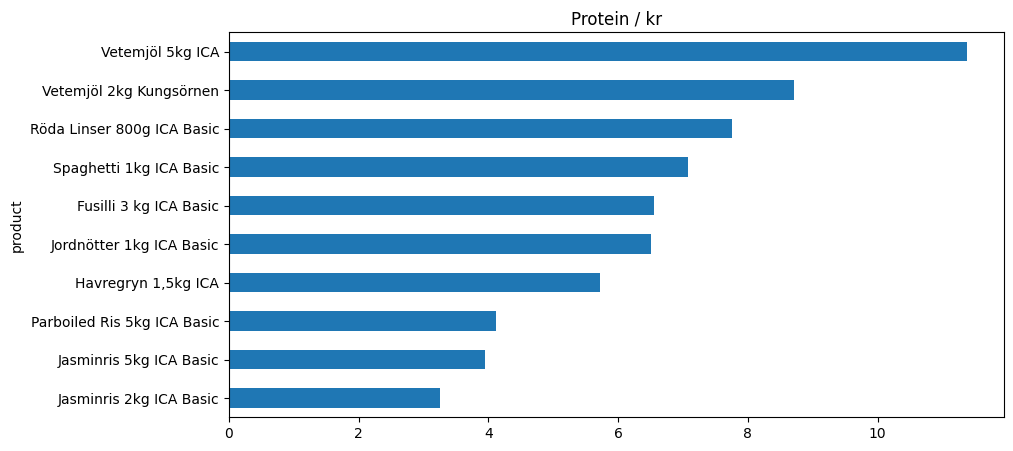

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
super_foods.prot_per_kr.nlargest(10).sort_values(ascending=True).plot(kind="barh", title="Protein / kr")

<Axes: title={'center': 'Kcal / kr'}, ylabel='product'>

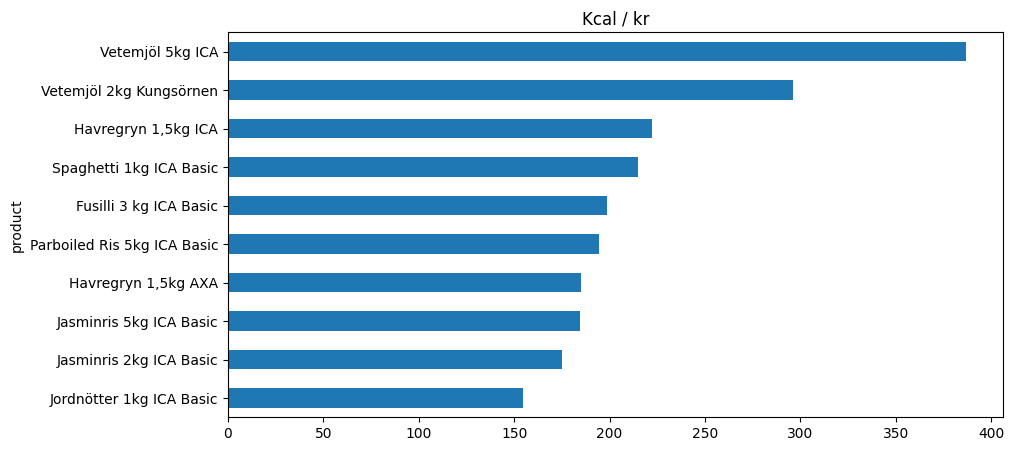

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
super_foods.kcal_per_kr.nlargest(10).sort_values(ascending=True).plot(kind="barh", title="Kcal / kr")

<Axes: title={'center': 'Protein / kcal'}, ylabel='product'>

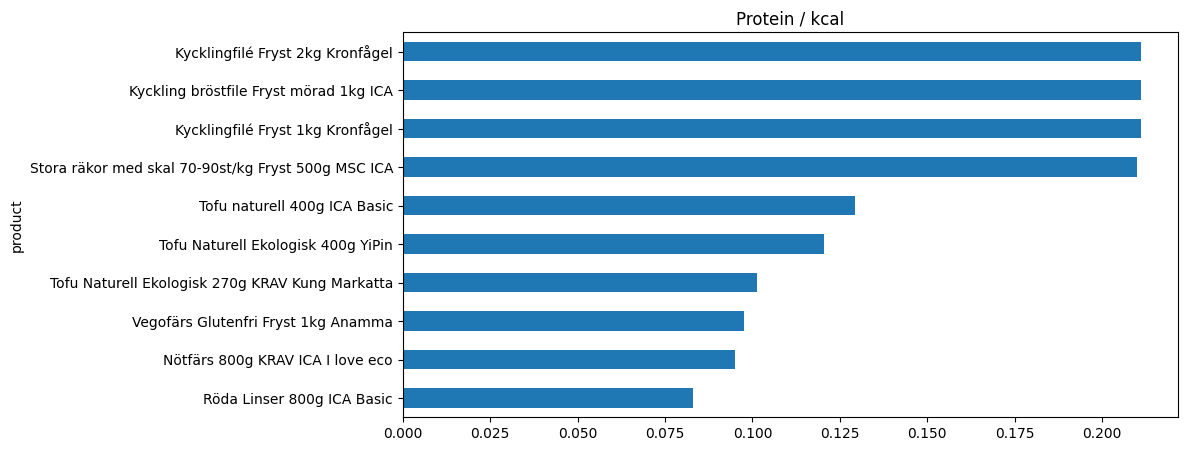

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
super_foods.prot_per_kcal.nlargest(10).sort_values(ascending=True).plot(kind="barh", title="Protein / kcal")